In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score
from lifelines.utils import concordance_index

In [3]:
# File paths for the five splits
train_files = [
    'E:/HTWD/train_split_1.csv',
    'E:/HTWD/train_split_2.csv',
    'E:/HTWD/train_split_3.csv',
    'E:/HTWD/train_split_4.csv',
    'E:/HTWD/train_split_5.csv',
    'E:/HTWD/pyradiomics_train_data-Copy.csv'
]
test_files = [
    'E:/HTWD/test_split_1.csv',
    'E:/HTWD/test_split_2.csv',
    'E:/HTWD/test_split_3.csv',
    'E:/HTWD/test_split_4.csv',
    'E:/HTWD/test_split_5.csv',
    'E:/HTWD/test_data_greyvalues_pyradiomics.csv'
]

In [5]:
days_of_interest = [0, 3, 5, 7, 10, 12, 14]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
# Define the feature selectors and models
feature_selectors = {
    'Lasso': SelectFromModel(Lasso(alpha=0.01,max_iter=5000, random_state=42))
}

models = {
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

In [9]:
def load_and_filter_data(file_path, days):
    try:
        df = pd.read_csv(file_path)
        df_filtered = df[df['day'].isin(days)]
        return df_filtered
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Function to pivot and prepare the dataset
def pivot_and_prepare_data(df):
    df_pivot = df.pivot_table(index='well', columns='day', values=[col for col in df.columns if col not in ['well', 'day', 'diagnosis']])
    df_pivot.columns = [f'{feat}_day{day}' for feat, day in df_pivot.columns]
    df_final = pd.merge(df_pivot, df[['well', 'diagnosis']].drop_duplicates(), on='well')
    X = df_final.drop(columns=['diagnosis', 'well'])
    y = df_final['diagnosis'].map({'relapsed': 1, 'controlled': 0})
    return X, y

In [11]:
metrics_by_day_train = {}
metrics_by_day_test = {}
metrics_by_day_val = {}

for split_num in range(6):
    print(f"Processing split {split_num+1}...")

    # Load and filter training and test data
    df_train = load_and_filter_data(train_files[split_num], days_of_interest)
    df_test = load_and_filter_data(test_files[split_num], days_of_interest)

    # Check if the dataframes were loaded successfully before proceeding
    if df_train is not None and df_test is not None:
        X_train, y_train = pivot_and_prepare_data(df_train)
        X_test, y_test = pivot_and_prepare_data(df_test)

        # Split the pivoted dataset into training and validation sets
        X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

        # Loop over feature selectors and models
        for fs_name, selector in feature_selectors.items():
            print(f"Using feature selector: {fs_name}")
            for model_name, model in models.items():
                key = f"{fs_name} + {model_name} (Split {split_num+1})"

                # Initialize lists to store metrics across days for each feature selector + model combination
                metrics_by_day_train[key] = {'roc_auc': [], 'c_index': [], 'f1_score': []}
                metrics_by_day_test[key] = {'roc_auc': [], 'c_index': [], 'f1_score': []}
                metrics_by_day_val[key] = {'roc_auc': [], 'c_index': [], 'f1_score': []}

                for day_idx, day in enumerate(days_of_interest):
                    days_up_to_current = days_of_interest[:day_idx+1]
                    X_train_day = X_train_split.loc[:, [col for col in X_train_split.columns if any(f'_day{d}' in col for d in days_up_to_current)]]
                    X_test_day = X_test.loc[:, [col for col in X_test.columns if any(f'_day{d}' in col for d in days_up_to_current)]]
                    X_val_day = X_val.loc[:, [col for col in X_val.columns if any(f'_day{d}' in col for d in days_up_to_current)]]

                    if X_train_day.shape[1] == 0 or X_test_day.shape[1] == 0 or X_val_day.shape[1] == 0:
                        print(f"Skipping day {day} because no features are available.")
                        continue

                    # Create a pipeline with variance filtering, scaling, and the feature selector
                    pipeline = Pipeline(steps=[
                        ('scaler', StandardScaler()),  
                        ('feature_selection', selector),
                        ('model', model)
                    ])

                    # Perform cross-validation on the training set
                    y_pred_prob_cv = cross_val_predict(pipeline, X_train_day, y_train_split, cv=kf, method='predict_proba')[:, 1]
                    auc_train = roc_auc_score(y_train_split, y_pred_prob_cv)
                    c_index_train = concordance_index(y_train_split, y_pred_prob_cv)
                    f1_train = f1_score(y_train_split, (y_pred_prob_cv > 0.5).astype(int))

                    metrics_by_day_train[key]['roc_auc'].append(auc_train)
                    metrics_by_day_train[key]['c_index'].append(c_index_train)
                    metrics_by_day_train[key]['f1_score'].append(f1_train)

                    # Fit and predict on the test set
                    pipeline.fit(X_train_day, y_train_split)
                    y_pred_prob_test = pipeline.predict_proba(X_test_day)[:, 1]
                    auc_test = roc_auc_score(y_test, y_pred_prob_test)
                    c_index_test = concordance_index(y_test, y_pred_prob_test)
                    f1_test = f1_score(y_test, (y_pred_prob_test > 0.5).astype(int))

                    metrics_by_day_test[key]['roc_auc'].append(auc_test)
                    metrics_by_day_test[key]['c_index'].append(c_index_test)
                    metrics_by_day_test[key]['f1_score'].append(f1_test)

                    y_pred_prob_val = pipeline.predict_proba(X_val_day)[:, 1]
                    auc_val = roc_auc_score(y_val, y_pred_prob_val)
                    c_index_val = concordance_index(y_val, y_pred_prob_val)
                    f1_val = f1_score(y_val, (y_pred_prob_val > 0.5).astype(int))

                    metrics_by_day_val[key]['roc_auc'].append(auc_val)
                    metrics_by_day_val[key]['c_index'].append(c_index_val)
                    metrics_by_day_val[key]['f1_score'].append(f1_val)

metrics_train_df = pd.DataFrame(metrics_by_day_train)
metrics_test_df = pd.DataFrame(metrics_by_day_test)
metrics_val_df = pd.DataFrame(metrics_by_day_val)

metrics_train_df.to_csv('E:/HTWD/Metrics/metrics_train.csv', index=False)
metrics_test_df.to_csv('E:/HTWD/Metrics/metrics_test.csv', index=False)
metrics_val_df.to_csv('E:/HTWD/Metrics/metrics_val.csv', index=False)

Processing split 1...
Using feature selector: Lasso
Processing split 2...
Using feature selector: Lasso
Processing split 3...
Using feature selector: Lasso
Processing split 4...
Using feature selector: Lasso
Processing split 5...
Using feature selector: Lasso
Processing split 6...
Using feature selector: Lasso


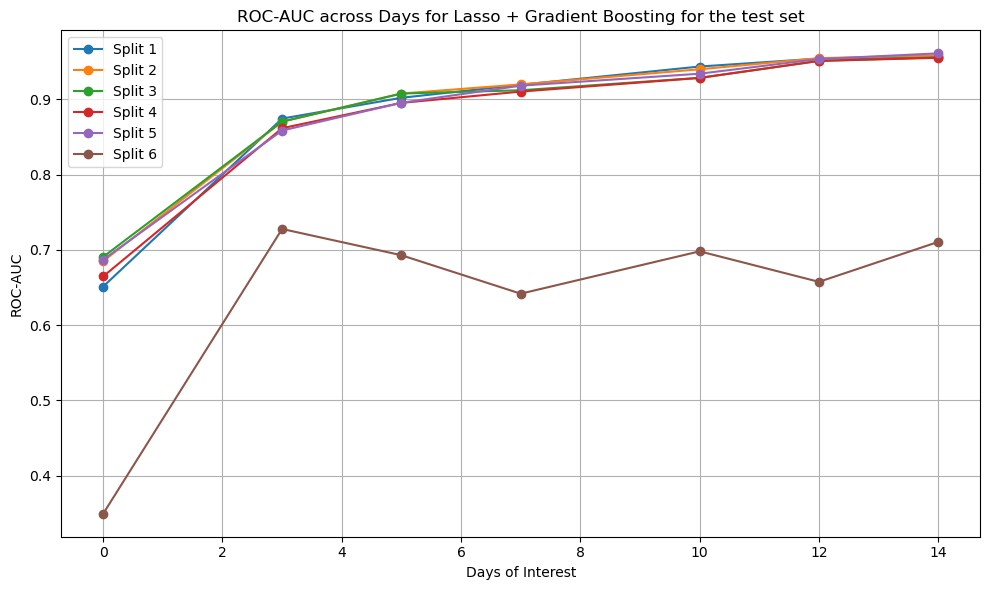

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Days of interest (x-axis values)
days_of_interest = [0, 3, 5, 7, 10, 12, 14]

# Extract ROC-AUC values from the DataFrame (assuming they are stored as lists)
# If the values are already lists, we can use them directly
roc_auc_split_1 = metrics_test_df['Lasso + Gradient Boosting (Split 1)'].apply(lambda x: x if isinstance(x, list) else eval(x))
roc_auc_split_2 = metrics_test_df['Lasso + Gradient Boosting (Split 2)'].apply(lambda x: x if isinstance(x, list) else eval(x))
roc_auc_split_3 = metrics_test_df['Lasso + Gradient Boosting (Split 3)'].apply(lambda x: x if isinstance(x, list) else eval(x))
roc_auc_split_4 = metrics_test_df['Lasso + Gradient Boosting (Split 4)'].apply(lambda x: x if isinstance(x, list) else eval(x))
roc_auc_split_5 = metrics_test_df['Lasso + Gradient Boosting (Split 5)'].apply(lambda x: x if isinstance(x, list) else eval(x))
roc_auc_split_6 = metrics_test_df['Lasso + Gradient Boosting (Split 6)'].apply(lambda x: x if isinstance(x, list) else eval(x))
# Now extract the actual lists of ROC-AUC scores for each split
roc_auc_split_1 = roc_auc_split_1.iloc[0]
roc_auc_split_2 = roc_auc_split_2.iloc[0]
roc_auc_split_3 = roc_auc_split_3.iloc[0]
roc_auc_split_4 = roc_auc_split_4.iloc[0]
roc_auc_split_5 = roc_auc_split_5.iloc[0]
roc_auc_split_6 = roc_auc_split_6.iloc[0]
# Plot the ROC-AUC across days for each split
plt.figure(figsize=(10, 6))

plt.plot(days_of_interest, roc_auc_split_1, label='Split 1', marker='o')
plt.plot(days_of_interest, roc_auc_split_2, label='Split 2', marker='o')
plt.plot(days_of_interest, roc_auc_split_3, label='Split 3', marker='o')
plt.plot(days_of_interest, roc_auc_split_4, label='Split 4', marker='o')
plt.plot(days_of_interest, roc_auc_split_5, label='Split 5', marker='o')
plt.plot(days_of_interest, roc_auc_split_6, label='Split 6', marker='o')

plt.xlabel('Days of Interest')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC across Days for Lasso + Gradient Boosting for the test set')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
